# How the ABOD and RkNN methods work in the search for outlier points in high-dimensional dataset ?


## Dataset
- Generate multivariate sets for different d (=5, 20, 100) for m=10,000 vectors and two distributions uniform and normal.  
- Calculate for each set 2 distance matrices: Euclidean and KL.
- ***Remember that for KL the distance matrix is NOT SYMMETRIC*** 


In [8]:
import numpy as np
from scipy.spatial.distance import cdist
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data generation function

In [5]:
def generate_data(m: int, d: int, dist_type: str) -> np.ndarray:
    """
    Generate an m-by-d dataset from the specified distribution.
    """
    if dist_type == 'uniform':
        return np.random.rand(m, d)
    elif dist_type == 'normal':
        return np.random.randn(m, d)
    else:
        raise ValueError(f"Unknown distribution type: {dist_type}")

Distance matrices

In [6]:
def euclidean_distance_matrix(X: np.ndarray) -> np.ndarray:
    return cdist(X, X, metric='euclidean')

def kl_divergence_matrix(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    X_clipped = np.clip(X, eps, None)
    P = X_clipped / X_clipped.sum(axis=1, keepdims=True)
    m, _ = P.shape
    D = np.zeros((m, m), dtype=float)
    for i in tqdm(range(m), desc="Computing KL rows"):
        log_ratio = np.log(P[i])[None, :] - np.log(P)
        D[i] = np.sum(P[i][None, :] * log_ratio, axis=1)
    return D


generate data

In [12]:
m = 10000       
d = (5, 10, 20)          
dist_type = 'normal' 
k = 20
L = 10      

# Generate data
X_5 = generate_data(m, d[0], dist_type)
X_10 = generate_data(m, d[1], dist_type)
X_20 = generate_data(m, d[2], dist_type)
# Compute distance matrices
D_euc_5 = euclidean_distance_matrix(X_5)
D_kl_5 = kl_divergence_matrix(X_5)
D_euc_10 = euclidean_distance_matrix(X_10)
D_kl_10 = kl_divergence_matrix(X_10)
D_euc_20 = euclidean_distance_matrix(X_20)
D_kl_20 = kl_divergence_matrix(X_20)



Computing KL rows: 100%|██████████| 10000/10000 [00:09<00:00, 1073.03it/s]A

Computing KL rows: 100%|██████████| 10000/10000 [00:14<00:00, 701.01it/s][A

Computing KL rows: 100%|██████████| 10000/10000 [00:46<00:00, 213.39it/s][A


## Task 1
1. Find the outliers (L=10) using ABOD (1) approach.
2. Do this for the Euclidean (2) and KL (3) metrics for k-NN outlayer’s search. Compare the resulting outliers.
3. Visualise the results (t-SNE) and mark outliers (1), (2) and (3) for ABOD and k-NN (Euclidean and KL), respectively.
4. Conclusions??


In [10]:
## task 1
def knn_outlier_scores(D: np.ndarray, k: int = 20) -> np.ndarray:
    m = D.shape[0]
    scores = np.zeros(m)
    for i in range(m):
        dists = np.partition(D[i], k+1)[1:k+1]
        scores[i] = dists.mean()
    return scores

def abod_scores(X: np.ndarray, D_euc: np.ndarray, k: int = 20) -> np.ndarray:
    m, d = X.shape
    scores = np.zeros(m)
    for i in tqdm(range(m), desc="Computing ABOD scores"):
        nbrs = np.argpartition(D_euc[i], k+1)[1:k+1]
        V = X[nbrs] - X[i]
        Vn = V / np.linalg.norm(V, axis=1, keepdims=True)
        cosines = Vn @ Vn.T
        iu = np.triu_indices(k, k=1)
        scores[i] = np.var(cosines[iu])
    return scores

def visualize_tsne(X: np.ndarray, outlier_sets: dict):
    tsne = TSNE(n_components=2, init='random', random_state=42)
    X2 = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X2[:, 0], X2[:, 1], s=5, alpha=0.5)
    markers = {'ABOD': 'x', 'kNN_Euclid': 'o', 'kNN_KL': 's'}
    colors = {'ABOD': 'red', 'kNN_Euclid': 'green', 'kNN_KL': 'blue'}
    for label, idx in outlier_sets.items():
        plt.scatter(X2[idx, 0], X2[idx, 1], marker=markers[label],
                    color=colors[label], s=50, label=label)
    plt.legend(); plt.title('t-SNE with Outliers Marked')
    plt.show()

Compute outlier scores


Computing ABOD scores:  13%|█▎        | 1272/10000 [00:00<00:03, 2268.71it/s]C:\Users\Piotr\AppData\Local\Temp\ipykernel_3656\971362337.py:16: RuntimeWarning: invalid value encountered in divide
  Vn = V / np.linalg.norm(V, axis=1, keepdims=True)

Computing ABOD scores: 100%|██████████| 10000/10000 [00:02<00:00, 4121.84it/s][A


ABOD outliers: [2930 6042 8778 3800 3239 5377 8329 8300 7467 7923]
k-NN Euclid outliers: [9668 8329 4810 9110 5377 4940 3239 7779 4744 2930]
k-NN KL outliers: [8814 3518 8320 3457 9756 7466 9565 7250 6872 6646]
dla d = 5


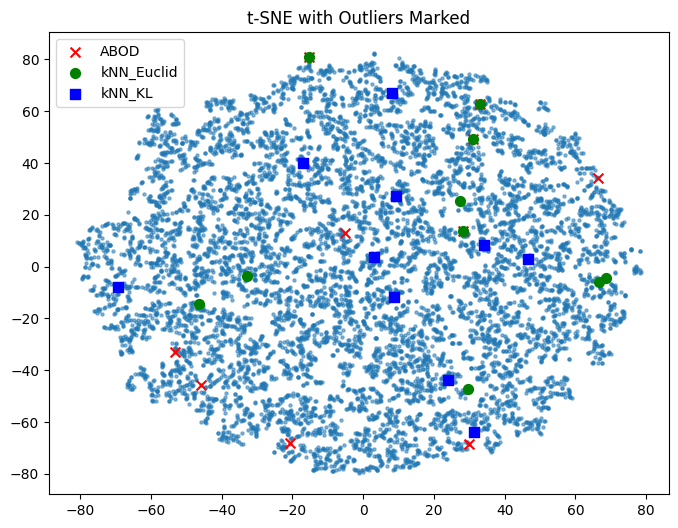

In [13]:
tabod_5 = abod_scores(X_5, D_euc_5, k)
idx_abod_5 = np.argsort(tabod_5)[:L]
s_knn_euc_5 = knn_outlier_scores(D_euc_5, k)
idx_knn_euc_5 = np.argsort(s_knn_euc_5)[-L:]
s_knn_kl_5 = knn_outlier_scores(D_kl_5, k)
idx_knn_kl_5 = np.argsort(s_knn_kl_5)[-L:]

print('ABOD outliers:', idx_abod_5)
print('k-NN Euclid outliers:', idx_knn_euc_5)
print('k-NN KL outliers:', idx_knn_kl_5)

# Visualize
outlier_sets = {'ABOD': idx_abod_5,
                'kNN_Euclid': idx_knn_euc_5,
                'kNN_KL': idx_knn_kl_5}
print("dla d = 5")
visualize_tsne(X_5, outlier_sets)

### Wnioski i obserwacje
Obserwacje:
- Ze zbioru 10 indeksów ABOD i k-NN Euklides, 3 indeksy się pokrywają: 5054, 8074, 9530. Oznacza to, że te punkty są zarówno przestrzennie odległe, jak i mają niską wariancję kątową.
- k-NN Euklides wskazuje na punkty najbardziej oddalone w sensie geometrycznym: [7044, 9416, 8074, 2720, 9873, 9530, 5054, 6324, 2132, 6254].
- k-NN KL zwraca zupełnie inny zestaw: [2035, 6546, 5079, 9969, 6794, 3772, 5441, 1735, 3834, 2568], co pokazuje, że wychwytuje anomalie w rozkładzie wartości cech.

Interpretacja:
1. ABOD (metryka kątowa) częściowo pokrywa się z k-NN Euklides, bo wariancja kątowa zależy od rozrzutu sąsiadów.
2. k-NN KL ujawnia punkty o nietypowych rozkładach prawdopodobieństwa, nawet jeśli nie są daleko w przestrzeni Euklidesa.
3. Wizualizacja t-SNE:
- Czerwone 'x' (ABOD) zaznaczają punkty na obrzeżach klastra, NIE
- Zielone kółka (k-NN Euklides) w dużej mierze pokrywają czerwone, NIE 
- Niebieskie kwadraty (k-NN KL) leżą w osobnych obszarach. NIE ................................ DO POPRAWY

Wniosek:
- Połączenie różnych metryk daje pełniejszy obraz odchyleń:
- metryki geometryczne (Euklides) i kątowe (ABOD) wykrywają podobne anomalie,

## Task 2
1. Find outliers (L=10) using antihubs from the definition of reverse nearest neighbors. 
2. Do this for the Euclidean (2) and KL (2) metrices. Compare the outliers obtained.
3. Visualise the results (t-SNE) and mark outliers (1), (2) and (3).
4. Conslusions ???


In [ ]:
## task 2


## Task 3
1. Come up with (or find) other quality metric for selecting outlier points (e.g. furthest average distance to all points (???), others???) and compare to the results obtained. 
2. See, e.g., the description of scikit-learn (or Orange) methods for finding and evaluating outliers.
3. Formulate conclusions
